In [333]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [334]:
import autoencoder.aecExtraFeatures as Z_calculations

def addZToPrediction(model, data_point):
    encoded = model.encoder(data_point)
    reconstruction = model.decoder(encoded)

    Z_features = [Z_calculations.getZVector(data_point, reconstruction, encoded)]

    Z_features_tensor = tf.convert_to_tensor(Z_features, dtype=tf.float32)
    data_point = tf.convert_to_tensor(data_point, dtype=tf.float32)

    data_point = tf.concat([data_point, Z_features_tensor], 1)

    return data_point

In [335]:
def isAnomaly(data_point, model_1, model_2, threshold):

    # need autoencoder to return boolean isAnomaly
    isAnomaly = tf.math.less(tf.keras.losses.mae(model_1(data_point), data_point), threshold)

    # if the autoencoder doesn't find anything out of the ordinary, return False
    if not isAnomaly:
        return False

    data_point = addZToPrediction(model_1, data_point)

    # if the autoencoder sees something weird, run it through the isolation forest to make sure
    return model_2.predict(data_point)

In [336]:
from turtleIsolationForests.preprocessFeatures import preprocess_features

train_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_train.csv", index_col=0)
test_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_test.csv", index_col=0)

train_data, test_data, train_labels, test_labels = preprocess_features(train_dataframe, test_dataframe)

In [337]:
train_data, test_data, train_labels, test_labels = train_data[:1000], test_data[:1000], train_labels[:1000], test_labels[:1000]

In [338]:
np_train_labels = train_labels.to_numpy()
np_test_labels = test_labels.to_numpy()

In [339]:
np_train_data = train_data.to_numpy()
np_test_data = test_data.to_numpy()

In [340]:
np_train_data = tf.cast(np_train_data, tf.float32)
np_test_data = tf.cast(np_test_data, tf.float32)

In [341]:
np_train_labels = np_train_labels.astype(bool)
np_test_labels = np_test_labels.astype(bool)

normal_train_data = np_train_data[np_train_labels]
normal_test_data = np_test_data[np_test_labels]

anomalous_train_data = np_train_data[~np_train_labels]
anomalous_test_data = np_test_data[~np_test_labels]

In [342]:
from autoencoder.autoencoder import AnomalyDetector
autoencoder = AnomalyDetector()

In [343]:
autoencoder.compile(optimizer='adam', loss='mae')

In [344]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=100,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
Tensor("anomaly_detector_6/sequential_12/dense_38/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_6/sequential_13/dense_41/Sigmoid:0", shape=(None, 46), dtype=float32)
Tensor("anomaly_detector_6/sequential_12/dense_38/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_6/sequential_13/dense_41/Sigmoid:0", shape=(None, 46), dtype=float32)
 1/17 [>.............................] - ETA: 25s - loss: 0.7303Tensor("anomaly_detector_6/sequential_12/dense_38/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_6/sequential_13/dense_41/Sigmoid:0", shape=(None, 46), dtype=float32)
17/17 [==============================] - 2s 23ms/step - loss: 0.7158 - val_loss: 0.7816
Epoch 2/100
17/17 [==============================] - 0s 8ms/step - loss: 0.6390 - val_loss: 0.6773
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 0.4685 - val_loss: 0.5486
Epoch 4/100
17/17 [==============================] - 0s 7ms/step - loss: 0.3627 

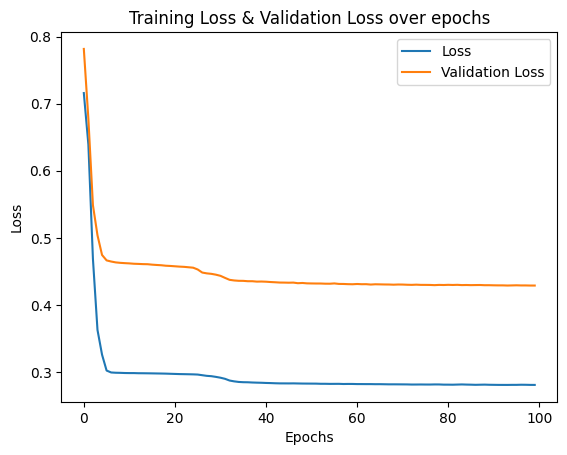

In [345]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training Loss & Validation Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim([0,.0008])
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [346]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Tensor("anomaly_detector_6/sequential_12/dense_38/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_6/sequential_13/dense_41/Sigmoid:0", shape=(None, 46), dtype=float32)
17/17 [==============================] - 0s 1ms/step
Threshold:  0.4064331


In [347]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(data, reconstructions) # 0 = anomaly (same as data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [348]:
%%timeit
%%capture

predict(autoencoder, np_test_data, threshold)

13.6 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [349]:
%%capture

test_predictions = predict(autoencoder, np_test_data, threshold)

### Stats for whole dataset

In [350]:
print_stats(test_predictions, test_labels)

Accuracy = 0.812
Precision = 0.7391304347826086
Recall = 0.9026548672566371


In [351]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_labels, test_predictions))

[[404 144]
 [ 44 408]]


In [352]:
test_labels_swap = []
for i in range(len(test_labels)):
    if test_labels[i]:
        test_labels_swap.append(False)
    else:
        test_labels_swap.append(True)

test_labels = test_labels_swap
np_test_labels = test_labels

### Stats for all predicted anomalous data

In [353]:
from pandas import DataFrame
from turtleIsolationForests.printResults import print_results

test_predictions_np = test_predictions.numpy()

autoec_predictions = DataFrame()

autoec_predictions['predicted_as_anomaly'] = test_predictions_np
autoec_predictions['is_normal'] = test_labels

print_results(autoec_predictions)

true anomalies: 408
false anomalies: 144
false normals: 44
true normals: 404
precision: 0.7391304347826086
recall: 0.9026548672566371
f1-score: 0.8127490039840637


In [354]:
def addZToData(data, model):
    data_with_Z = []
    for i in range(1, len(data)+1):
        data_with_Z.append(addZToPrediction(model, data[i-1:i]))

    data_with_Z_rf = []
    for i in range(len(data_with_Z)):
        data_with_Z_rf.append(np.append(np_train_data[:][:][i].numpy().reshape(1,46).squeeze(), data_with_Z[i]))

    return pd.DataFrame(data_with_Z_rf)

In [355]:
train_data_with_Z_df = addZToData(np_train_data, autoencoder)

In [356]:
train_data_with_Z_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,0.000000,2.897089,0.116624
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.000000,4.931060,0.052502
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0.000000,5.080774,-0.196176
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,3.706993,2.350453,0.708277
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,4.880975,2.062329,0.752867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.019113,-0.312889,-0.11205,-0.028606,7.143771,-0.618438,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.121485,-0.447834,-0.289103,0.866823,-0.490241,-0.355014,-0.000751,0.000000,13.498476,0.049060
996,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.350745,0.066252,-0.639532,-0.624871,-0.387635,-0.376387,3.674186,2.560726,0.676336
997,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.068553,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0.000000,5.133149,-0.200215
998,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.068553,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0.091040,5.355477,-0.173446


In [357]:
np_test_labels = np.array(np_test_labels)

In [358]:
predicted_anomalous = np_test_data[test_predictions.numpy()]

In [359]:
train_data_with_Z_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,0.000000,2.897089,0.116624
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.000000,4.931060,0.052502
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0.000000,5.080774,-0.196176
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,3.706993,2.350453,0.708277
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,4.880975,2.062329,0.752867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.019113,-0.312889,-0.11205,-0.028606,7.143771,-0.618438,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.121485,-0.447834,-0.289103,0.866823,-0.490241,-0.355014,-0.000751,0.000000,13.498476,0.049060
996,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.350745,0.066252,-0.639532,-0.624871,-0.387635,-0.376387,3.674186,2.560726,0.676336
997,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.068553,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0.000000,5.133149,-0.200215
998,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.068553,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0.091040,5.355477,-0.173446


In [360]:
predicted_anomalous_labels = np_test_labels[test_predictions.numpy()]

In [361]:
anomalous_test_data_with_Z_df = addZToData(predicted_anomalous, autoencoder)

In [362]:
contamination = sum(train_labels == 0) / len(train_labels)

In [363]:
# need test_predictions replaced at indices that autoencoder predicted anomalies

In [364]:
anomalous_test_data_with_Z_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.227350,1.493939,-0.111426,-0.639532,-0.624871,-0.387635,-0.376387,0.000000,3.088438,0.113477
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.447834,-0.022587,-0.617049,-0.624871,-0.387635,-0.376387,4.124097,2.038764,0.756528
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,3.372038,-0.480197,-0.289103,-0.639532,-0.624871,1.961037,-0.251175,0.000000,5.691982,0.304321
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.447834,-0.022587,-0.639532,-0.624871,-0.387635,-0.376387,4.484724,1.946810,0.771582
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.386146,-0.480197,-0.289103,-0.639532,-0.624871,1.765315,0.625309,0.000000,3.327319,0.102927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,4.475514,2.494858,0.685989
548,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,4.544272,2.197386,0.731250
549,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,3.636698,-0.480197,-0.289103,-0.639532,-0.624871,2.026278,-0.376387,0.000000,4.806163,0.353027
550,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.386146,-0.480197,-0.289103,-0.639532,-0.624871,-0.224532,-0.219872,4.171893,2.417590,0.697079


In [365]:
def getFinalPredictions(first_predictions, second_predictions):
    f_p_copy = first_predictions
    s_p_copy = second_predictions
    indices = s_p_copy.index[f_p_copy["predicted_as_anomaly"] == True]
    s_p_copy.index = indices
    f_p_copy.loc[indices, "predicted_as_anomaly"] = s_p_copy["predicted_as_anomaly"]
    print_results(f_p_copy)

In [366]:
from turtleIsolationForests.extendedIsolationForest import ExtendedIsolationForest
from turtleIsolationForests.printResults import print_results

eif = ExtendedIsolationForest(contamination = contamination, random_state = None)
eif.fit(train_data_with_Z_df, train_labels)

Finished building forest
Finished calculating threshold


In [367]:
%%timeit

eif.predict(anomalous_test_data_with_Z_df)

2.55 s ± 231 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [368]:
eif_predictions = eif.predict(anomalous_test_data_with_Z_df)
eif_predictions['is_normal'] = predicted_anomalous_labels

#print_results(eif_predictions)
getFinalPredictions(autoec_predictions, eif_predictions)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 552 but corresponding boolean dimension is 1000

In [120]:
from turtleIsolationForests.sciForest import SCIsolationForest

scif = SCIsolationForest(contamination = contamination, num_hyperplanes_per_split=5, random_state = None)
scif.fit(train_data_with_Z_df, train_labels)

Finished building forest
Finished calculating threshold


In [121]:
%%timeit

scif.predict(anomalous_test_data_with_Z_df)

1min 39s ± 704 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [122]:
scif_predictions = scif.predict(anomalous_test_data_with_Z_df)
scif_predictions['is_normal'] = predicted_anomalous_labels

#print_results(scif_predictions)
getFinalPredictions(autoec_predictions, scif_predictions)

true anomalies: 4721
false anomalies: 2480
false normals: 4858
true normals: 2465
precision: 0.6556033884182753
recall: 0.4928489403904374
f1-score: 0.5626936829558998


In [123]:
from turtleIsolationForests.isolationForest import IsolationForest

isoforest = IsolationForest(contamination = contamination, random_state = None)
isoforest.fit(train_data_with_Z_df, train_labels)

Finished building forest
Finished calculating threshold


In [124]:
%%timeit

isoforest.predict(anomalous_test_data_with_Z_df)

27 s ± 590 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [125]:
isoforest_predictions = isoforest.predict(anomalous_test_data_with_Z_df)
isoforest_predictions['is_normal'] = predicted_anomalous_labels

#print_results(isoforest_predictions)
getFinalPredictions(autoec_predictions, isoforest_predictions)

true anomalies: 4730
false anomalies: 2503
false normals: 4849
true normals: 2442
precision: 0.6539471865062906
recall: 0.49378849566760624
f1-score: 0.5626933142993099


In [126]:
from turtleIsolationForests.FBIF import FBIsolationForest

fbif = FBIsolationForest(contamination = contamination, random_state = None)
fbif.fit(train_data_with_Z_df, train_labels)

Finished building forest
Finished calculating threshold


In [127]:
%%timeit

fbif.predict(anomalous_test_data_with_Z_df)

2min 42s ± 1.53 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [128]:
fbif_predictions = fbif.predict(anomalous_test_data_with_Z_df)
fbif_predictions['is_normal'] = predicted_anomalous_labels

#print_results(fbif_predictions)
getFinalPredictions(autoec_predictions, fbif_predictions)

true anomalies: 4758
false anomalies: 2499
false normals: 4821
true normals: 2446
precision: 0.6556428276147168
recall: 0.49671155652990917
f1-score: 0.5652173913043478
